# Looking at data from 2022-2023

This notebook is used to make prognostic evaluations of the snowpack structure during the winter of 2022-2023, before going to Finse to confront our model's predictions to observational data.

## 1. Predictions of internal structure based on lidar measures

### Imports and functions

In [1]:
import pandas as pd

In [2]:
%run little_awk_functions.py
%run parameters.py

In [3]:
def get_snow_events_timeseries(ds, time_window_std, std_threshold):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the snow depth before and after the event
    Args:
        ds: clean dataset with 'snow_surface' variable
        time_window_std: size of the rolling window to compute standard deviation
        std_threshold: standard deviation threshold above which the curve is considered to have strong variations > snow event
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.snow.rolling(time_window_std, center=True).std().values
    
    snow_events_occurrences = stdev > std_threshold   # booleans
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        
        start_date = start_time_indices[index]
        end_date = end_time_indices[index]
    
        start_snow_height = float(ds.snow.iloc[start_date])
        end_snow_height = float(ds.snow.iloc[end_date])
    
        if start_snow_height < end_snow_height:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)

In [4]:
def get_change_in_snow_depth_timeseries(ds, start_events, end_events, index_of_event):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: dataset containing the snow-depth data ('snow_surface' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow.iloc[start_date])
    end_snow_height = float(ds.snow.iloc[end_date])
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

In [5]:
def simulate_snowpack_timeseries(ds, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc_default, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2,
                                met_temp_data=[None], met_time_data=[0],
                                new_snow_ro=150, fit_top_of_snowfall_to_curve=False):
    '''
    Function that simulates the evolution of the snowpack over a certain period of time
    Args:
        ds: clean dataset
        nb_iterations: number of iterations
        
        end_accumulation_times: list of ending times of accumulations in seconds since data starting date
        end_erosion_times: list of ending times of erosions in seconds since data starting date
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        jj: number of layers initially present                    # TODO add units and default values
        dt: timestep (s)
        ro_layer(1*max_nb_of_layers) array containing density value (kg per m**3) for each layer
        ro_water: density of water (kg per m**3)
        ro_ice: density of ice (kg per m**3)
        t_old: (1*max_nb_of_layers) array containing temperature value (degrees Celcius) for each layer
        tf: ice fusion temperature (degrees Celcius)
        tsfc_default: surface temperature (degrees Celcius)
        dy_snow: (1*max_nb_of_layers) array containing depth value (m) for each layer
        age_layers: (1*max_nb_of_layers) array containing age (s) of each layer
        gamma: (1*max_nb_of_layers) array containing zeros
        cp_snow: thermal capacity of snow
        melt_flag: (1*max_nb_of_layers) array containing melt value (1 or 0) for each layer
        a1, a2: exponential parameters, empirically calibrated

        met_temp_data: array containing surface temperatures for each meteorological timestamp (degrees Celcius), default [None], i.e. use tsfc=tsfc_default
        met_time_data: array containing the meteorological timestamps (since start of simulation, in s), default [0]
        
        new_snow_ro: density of newly fallen snow in kg per m**3, default 150

        fit_top_of_snowfall_to_curve: boolean, if True the height of snowfalls will be such that the snow depth is the same as the one measured by lidar, default False
    Returns:
        ro_layer_evolution: list of the states of layers' density through time, format [[ro_layer_1, ro_layer_2, ro_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        temperature_evolution: list of the states of layers' temperature through time, format [[temp_layer_1, temp_layer_2, temp_layer_3, ...]_time_1, [...]_time_2, [...], ...]
    '''
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []

    if met_temp_data[0] != None:
        tsfc = float(met_temp_data[0])
    else:
        tsfc = tsfc_default

    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    temperature_index = 0
    
    for i in range(nb_iterations):

        if temperature_index<len(met_temp_data) and met_time_data[temperature_index]!=None and i*dt>=met_time_data[temperature_index]:
            if met_temp_data[temperature_index] != None:
                tsfc = float(met_temp_data[temperature_index])
            temperature_index += 1

        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            if fit_top_of_snowfall_to_curve:
                snow_depth_total = sum(dy_snow[i] for i in range(0,jj))
                ddepth = float(ds.snow_surface.isel(time=end_accumulation[accumulation_index])) - snow_depth_total
            else:
                ddepth = get_change_in_snow_depth_timeseries(ds, start_accumulation, end_accumulation, accumulation_index)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = tsfc
            dy_snow[jj] = ddepth
            age_layers[jj] = (nb_iterations-i) * dt           # age in seconds at end of simulation
            if t_old[jj] <= 0:
                melt_flag[jj] = 0
            else:
                melt_flag[jj] = 1
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            ddepth = get_change_in_snow_depth_timeseries(ds, start_erosion, end_erosion, erosion_index)
            erosion_index += 1
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0
                    ro_layer[jj] = 0
                    t_old[jj] = 0
                    age_layers[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, tf, dy_snow, melt_flag)
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution)

In [6]:
def plot_simul_and_signal_timeseries(ds, depth_evolution, nb_layers_to_plot, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion, ice_layers_times_indices=None,
                          my_title='Comparison between lidar-measured and simulated snow depth', save_file=False, my_file_name='my_fig.png', my_figsize=(15, 7)):
    '''
    Function to plot the simulated snowpack and lidar signal on the same plot
    Args:
        ds: clean dataset
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        nb_layers_to_plot: number of layers to plot
        data_start_date: first date of the dataset, pandas datetime format
        dt: timestep used in snowpack simulation
        nb_iterations: number of iterations used in snowpack simulation
        
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds

        ice_layers_times_indices: list of time indices where an ice ayer was detected, default None
        
        my_title: title of the figure, default 'Comparison between lidar-measured and simulated snow depth'
        save_file: boolean, default False
        my_file_name: name to be given to the saved file, default 'my_fig.png'
        my_figsize: figure size, default (15, 7)
    Returns:
    '''
    layers = np.zeros((nb_layers_to_plot, len(depth_evolution)))
    for i in range(len(depth_evolution)):
        layers[0][i] = depth_evolution[i][0]
    for layer_index in range(1, nb_layers_to_plot):
        for i in range(len(depth_evolution)):
            layers[layer_index][i] = depth_evolution[i][layer_index] + layers[layer_index-1][i]
    
    fig = plt.figure(figsize=my_figsize)
    times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
    
    for layer_index in range(nb_layers_to_plot):
        plt.plot(times, layers[layer_index], label='layer '+str(layer_index+1))

    if ice_layers_times_indices != None:
        for time_index in ice_layers_times_indices:
            plt.plot(times[time_index], layers[-1][time_index]+0.001, c='y', marker='*', markersize=15, label='ice layer detected')
        
    ds.snow.plot(c='k', alpha=0.2)

    ds.iloc[start_accumulation].snow.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
    ds.iloc[end_accumulation].snow.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
    ds.iloc[start_erosion].snow.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
    ds.iloc[end_erosion].snow.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')
    
    # plt.legend()
    plt.title(my_title)
    
    if save_file:
        fig.savefig(my_file_name)
    
    plt.show(block=False)

    return()

### Create dataset

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

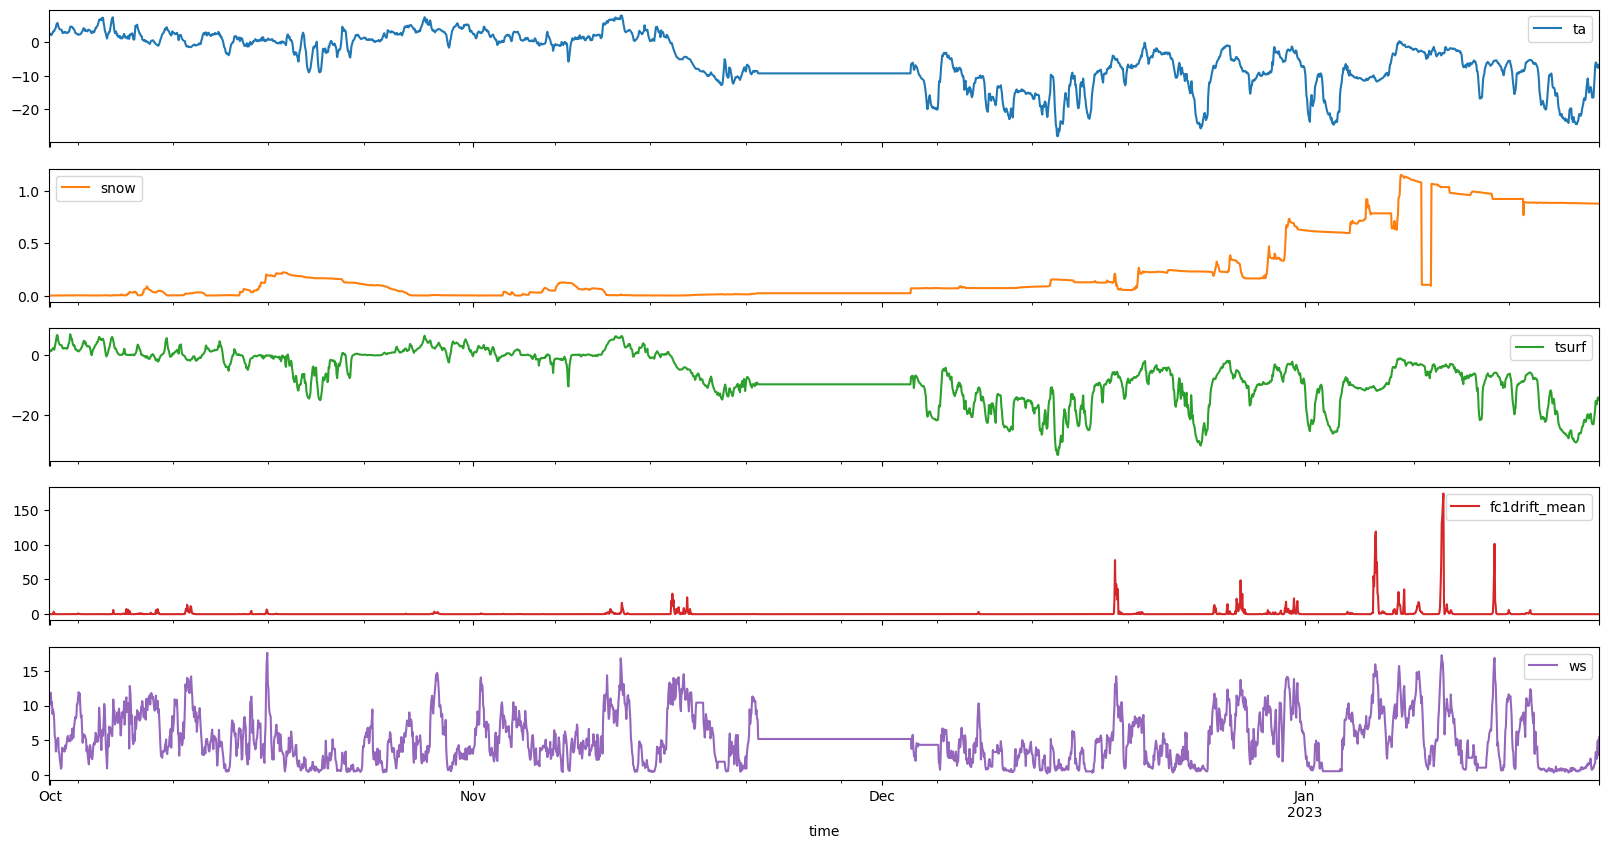

In [7]:
df = pd.read_pickle('20221001-20220121_finse_meteo_obs.pckl').ffill()
df['snow'] = df['snow'] / 100
df[['ta','snow','tsurf','fc1drift_mean', 'ws']].plot(figsize=(20,10), subplots=True)

In [8]:
# df is a data frame
# df['snow'] is a pandas series

type(df['snow'])

pandas.core.series.Series

In [9]:
data_set_used = df.to_xarray()

In [10]:
# Pre-processing to get clean data

data_set_used = data_set_used.ffill(dim='time')

# Median filtering on time
data_set_used['snow_surface'] = (data_set_used['snow'].rolling(time=11, min_periods=11, center=True).median()) / 100

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].dropna('time').min()


### Get timing values

In [11]:
# Define dates

data_starting_date_in_ns = (pd.to_datetime('2022-09-30T22:00').timestamp()) * 1000000000

data_starting_date_in_s = pd.to_datetime('2022-09-30T22:00').timestamp()
data_ending_date_in_s = pd.to_datetime('2023-01-22T14:00').timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_starting_date = pd.to_datetime('2022-09-30T22:00')

In [12]:
# Get timing of events
std_threshold = 0.015

results = get_snow_events_timeseries(df, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = df.index[end_accumulation]
end_accumulation_times = (pd.to_datetime(end_accumulation_times).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = df.index[end_erosion]
end_erosion_times = (pd.to_datetime(end_erosion_times).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


### Simulate snowpack

In [13]:
# Simulate the snowpack

snowpack = simulate_snowpack_timeseries(df, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]


### Plot results

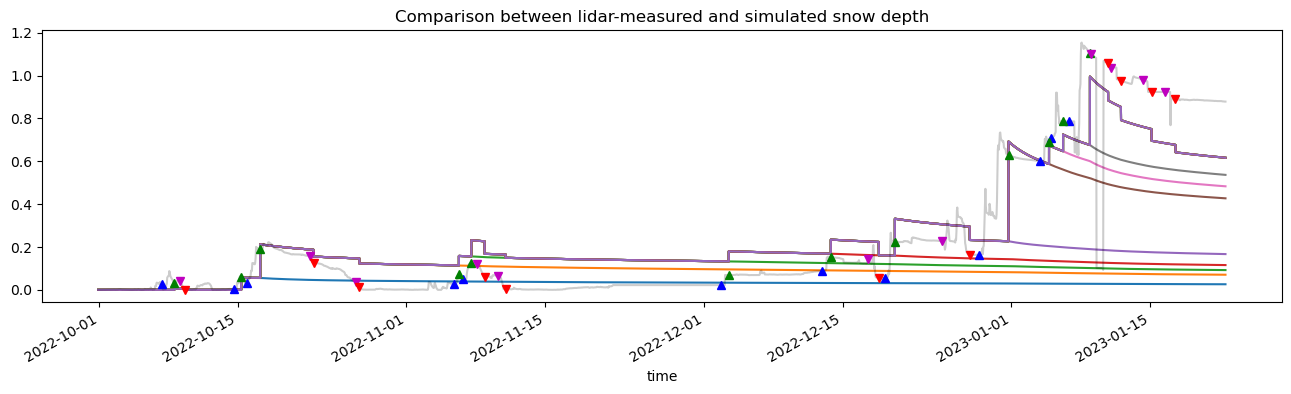

()

In [14]:
plot_simul_and_signal_timeseries(df, depth_evolution, 15, pd.to_datetime('2022-09-30T22:00'), dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, my_figsize=(16, 4), save_file=False)

<AxesSubplot:xlabel='time'>

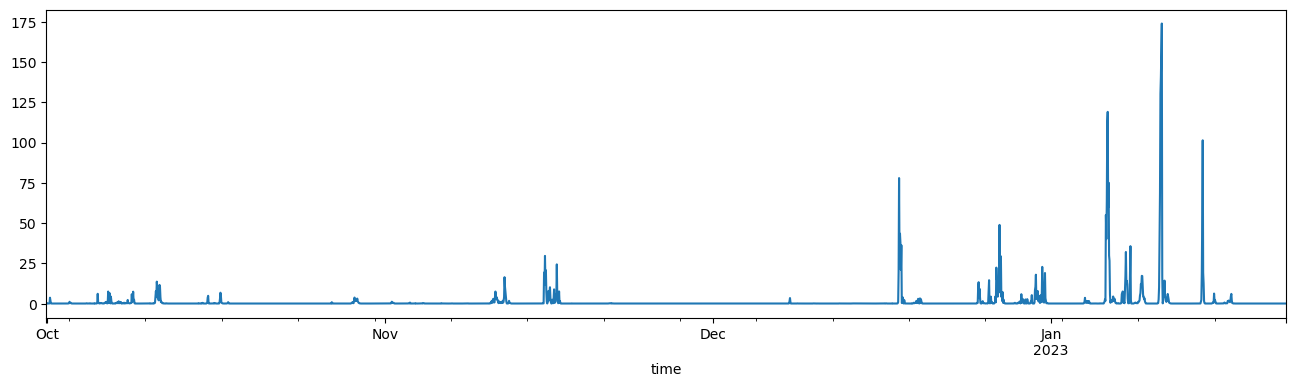

In [25]:
df['fc1drift_mean'].plot(figsize=(16, 4))

<AxesSubplot:xlabel='time'>

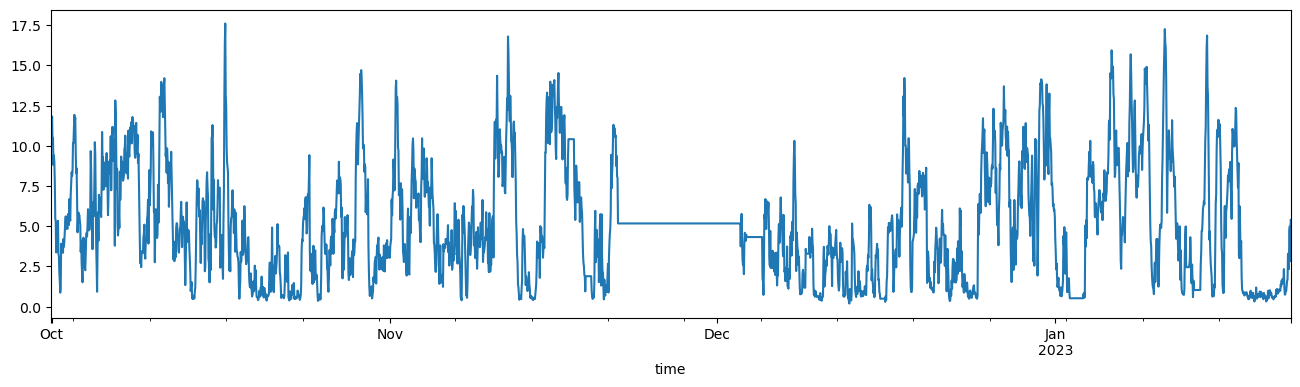

In [22]:
df['ws'].plot(figsize=(16, 4))

In [15]:
# TODO:
# - play around with std_threshold value to find a nice match

## 2. Identification of possible ice layers

<AxesSubplot:xlabel='time'>

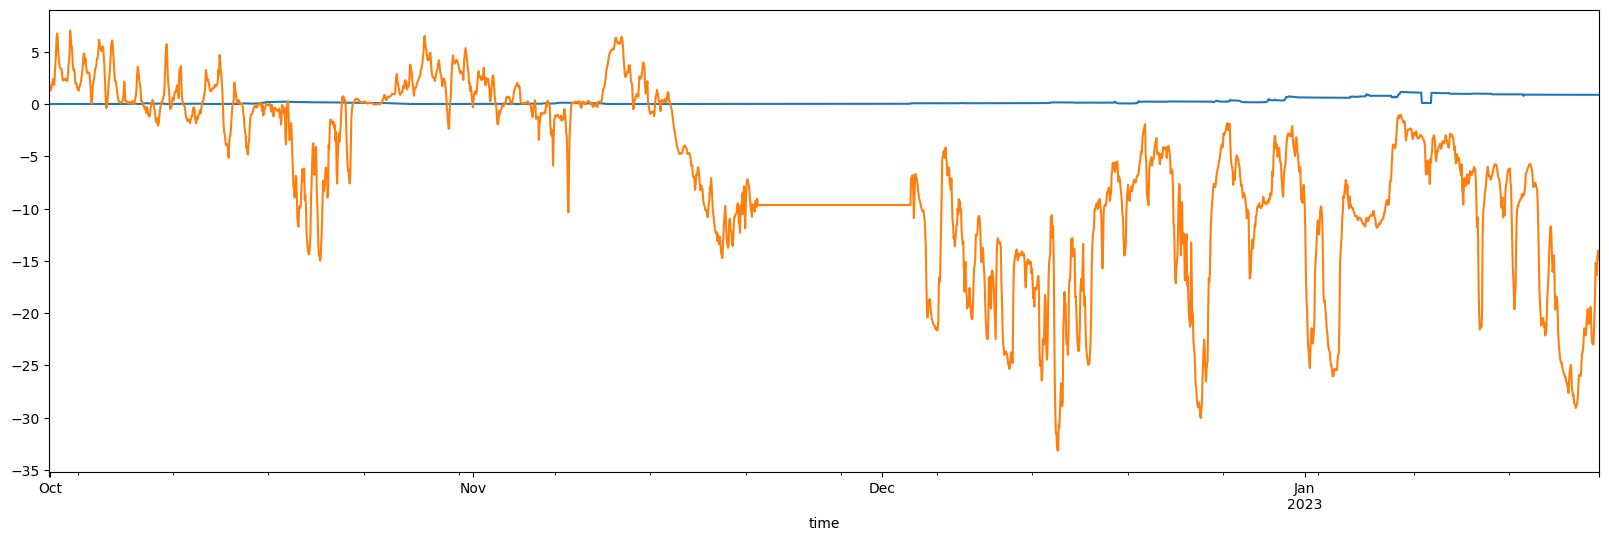

In [16]:
df['snow'].plot(figsize=(20,6))
df['tsurf'].plot()

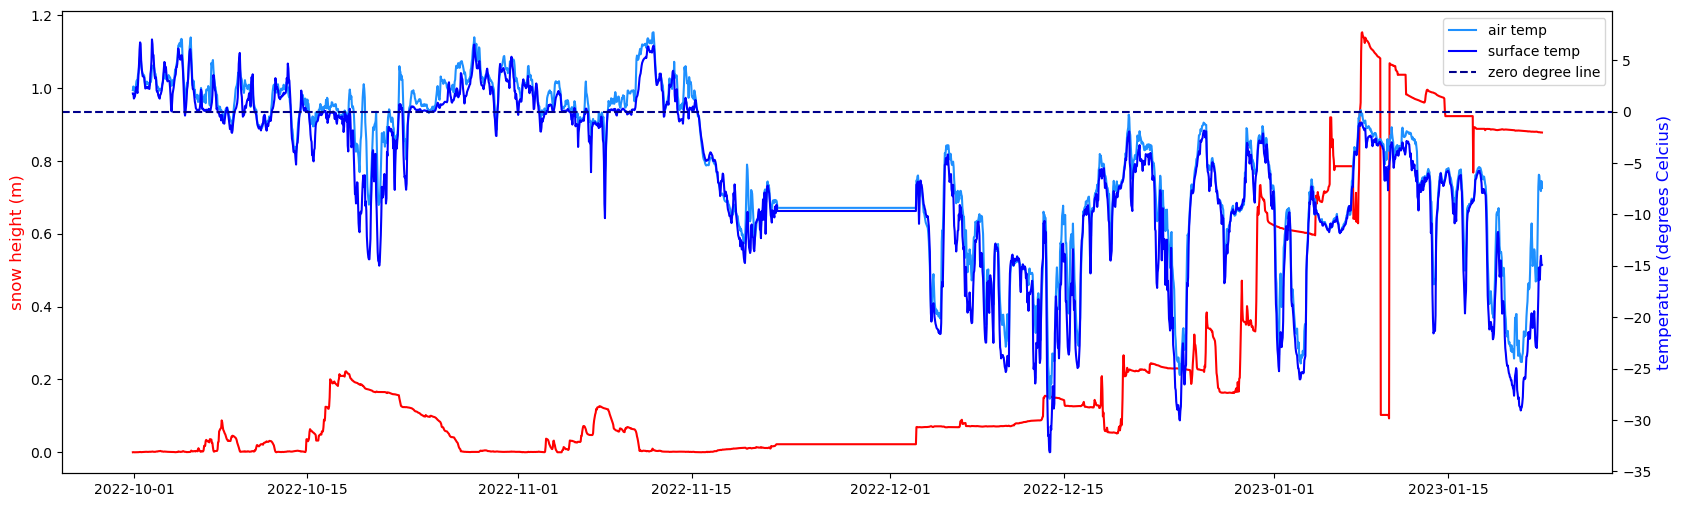

In [17]:
fig,ax = plt.subplots(figsize=(20,6))

ax.plot(df['snow'], color='red')
ax.set_ylabel('snow height (m)', color='red', fontsize=12)

ax2=ax.twinx()
ax2.plot(df['ta'], color='dodgerblue', label='air temp')
ax2.plot(df['tsurf'], color='blue', label='surface temp')
ax2.axhline(y = 0, color = 'darkblue', linestyle = '--', label='zero degree line')
ax2.set_ylabel('temperature (degrees Celcius)', color='blue', fontsize=12)

plt.legend()
plt.show()

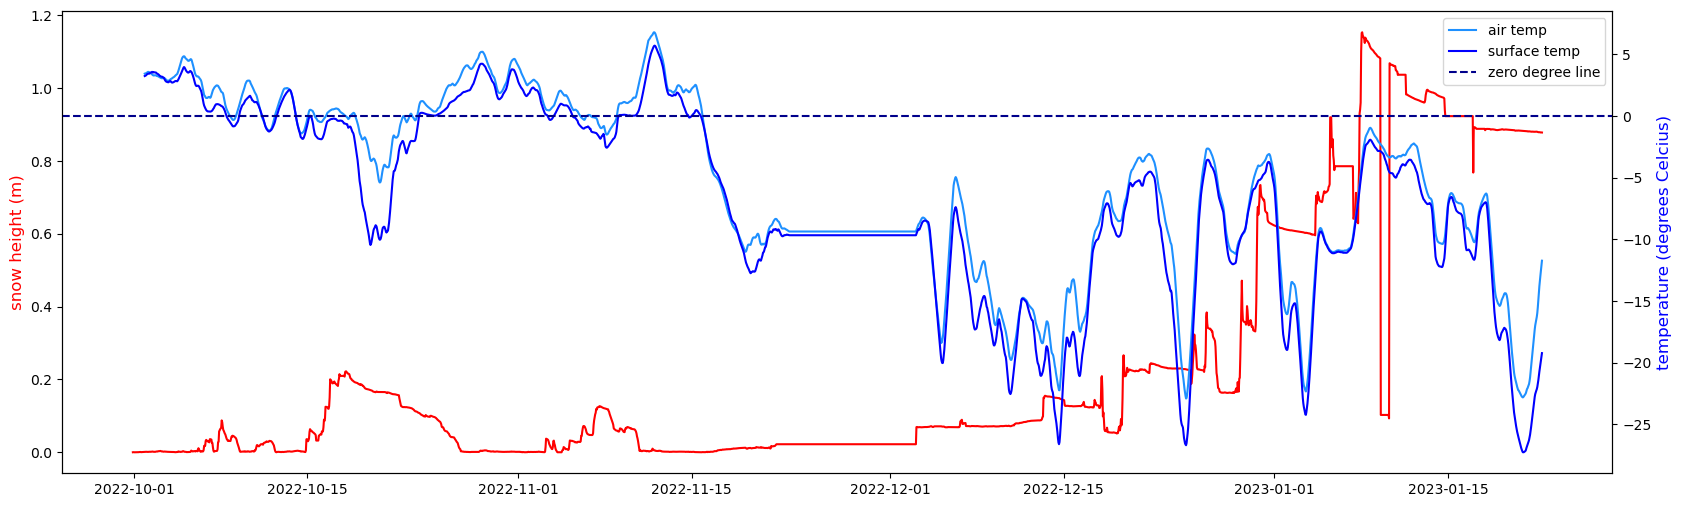

In [18]:
# Same figure with 24-hour mean temperature

fig,ax = plt.subplots(figsize=(20,6))

ax.plot(df['snow'], color='red')
ax.set_ylabel('snow height (m)', color='red', fontsize=12)

ax2=ax.twinx()
ax2.plot(df['ta'].rolling(24).mean(), color='dodgerblue', label='air temp')
ax2.plot(df['tsurf'].rolling(24).mean(), color='blue', label='surface temp')
ax2.axhline(y = 0, color = 'darkblue', linestyle = '--', label='zero degree line')
ax2.set_ylabel('temperature (degrees Celcius)', color='blue', fontsize=12)

plt.legend()
plt.show()

In [19]:
# TODO:
# - identify snow markers:
#     - plot times at which the temperature was high on the lidar+layers curve (new plot)
#     - identify potential ice layers